In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

In [2]:
def black_scholes_call(S, K, T, r, sigma):
    S = S[..., None, :]
    K = K[None, ..., None]
    T = T[None, None, None, :]
    sigma = sigma[None, :, None, None]

    call_prices = np.maximum(0, S - K) * (T <= 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_prices = np.where(T > 0, S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2), call_prices)

    return call_prices

def black_scholes_delta(S, K, T, r, sigma):
    S = S[..., None, :]
    K = K[None, ..., None]
    T = T[None, None, None, :]
    sigma = sigma[None, :, None, None]

    delta = np.where(T <= 0, np.where(S > K, 1.0, 0.0), 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = np.where(T > 0, norm.cdf(d1), delta)

    return delta

def update_cash_account_np(init_cash_account, shares_to_trade, stock_prices, r, T):
    b = np.concatenate((init_cash_account[...,None], - shares_to_trade * stock_prices[...,None,1:]),axis=-1)
    r_powers = np.exp(r*T)[None, None, None,:]
    a_series = np.cumsum(b * r_powers,axis=-1)[...,::-1] / r_powers[...,::-1]
    a_series = a_series[...,::-1]
    return a_series

In [3]:
class HedgingEnv:
    def __init__(self, S0, K, sigma, r, num_simulation=10_000, num_step=260, 
                 reward_type='step_wise', seed=0):
        """
        Initialize the Delta Hedging Environment
        
        Parameters:
        - S0: Initial stock prices (array of shape [num_asset])
        - K: Strike prices (array of shape [num_asset, num_strike_per_asset])
        - sigma: Volatilities (array of shape [num_asset])
        - r: Risk-free rate (scalar)
        - num_simulation: Number of simulations to run in parallel
        - num_step: Number of time steps in each simulation
        - reward_type: Type of reward function ('step_wise', 'terminal')
        - seed: Random seed for reproducibility
        """
        np.random.seed(seed)
        
        self.S0 = S0
        self.K = K
        self.sigma = sigma
        self.r = r
        self.num_simulation = num_simulation
        self.num_step = num_step
        self.reward_type = reward_type
        
        self.num_asset = len(S0)
        self.num_strike = K.shape[1]
        self.num_total_options = self.num_simulation * self.num_asset * self.num_strike
        
        # Time setup
        self.dt = 1.0 / num_step
        self.T = np.linspace(1, 0, num_step + 1)  # Time to maturity
        
        # Generate full simulations at initialization
        self._generate_simulations()
        
        # Current step counter
        self.current_step = 0
        
        # Store portfolio state
        self.cash_account = np.zeros((self.num_simulation, self.num_asset, 
                                     self.num_strike, self.num_step + 1))
        self.shares_held = np.zeros((self.num_simulation, self.num_asset, 
                                    self.num_strike, self.num_step + 1))
        
    def reset(self):
        """
        Reset the environment and return initial state
        """
        self.current_step = 0
        
        # Reset portfolio
        self.cash_account = np.zeros((self.num_simulation, self.num_asset, 
                                     self.num_strike, self.num_step + 1))
        self.shares_held = np.zeros((self.num_simulation, self.num_asset, 
                                    self.num_strike, self.num_step + 1))
        
        # Initial state features
        initial_state = self._create_features(0)
        
        return initial_state
        
    def step(self, actions):
        """
        Take a step in the environment based on actions
        
        Parameters:
        - actions: Delta values to use for hedging 
          (shape: [num_simulation * num_asset * num_strike])
        """
        if self.current_step >= self.num_step:
            raise Exception("Episode has ended. Please reset the environment.")
            
        # Reshape actions to match our dimensions
        actions_reshaped = actions.reshape(self.num_simulation, self.num_asset, self.num_strike)
        
        # Update portfolio based on actions (delta values)
        self._update_portfolio(actions_reshaped)
        
        # Move to next step
        self.current_step += 1
        
        # Get next state
        next_state = self._create_features(self.current_step)
        
        # Calculate rewards
        rewards = self._calculate_rewards()
        
        # Check if done
        done = np.full(self.num_total_options, self.current_step == self.num_step)
        
        # Additional info
        info = {
            'option_prices': self.option_prices[:, :, :, self.current_step].reshape(self.num_total_options),
            'portfolio_values': self._calculate_portfolio_values()[:, :, :, self.current_step].reshape(self.num_total_options)
        }
        
        return next_state, rewards, done, info
        
    def _generate_simulations(self):
        """Generate stock price simulations using Black-Scholes model"""
        # Expand S0 for simulations
        S0_expanded = np.tile(self.S0, (self.num_simulation, 1))[:, :, None]
        
        # Generate random normal shocks
        z = np.random.normal(0, 1, (self.num_simulation, self.num_asset, self.num_step))
        
        # Calculate log returns
        log_returns = (self.r - 0.5 * self.sigma[None, :, None]**2) * self.dt + \
                      self.sigma[None, :, None] * np.sqrt(self.dt) * z
                      
        # Calculate log stock prices
        log_S = np.log(S0_expanded) + np.cumsum(log_returns, axis=-1)
        
        # Convert to stock prices
        stock_prices = np.exp(log_S)
        
        # Add initial price at time 0
        self.stock_prices = np.concatenate((S0_expanded, stock_prices), axis=-1)
        
        # Calculate option prices
        self.option_prices = self._calculate_call_prices()
    
    def _calculate_call_prices(self):
        """Calculate option prices using Black-Scholes formula"""
        S = self.stock_prices[:, :, None, :]  # (num_simulation, num_asset, 1, num_step+1)
        K = self.K[None, :, :, None]  # (1, num_asset, num_strike, 1)
        T = self.T[None, None, None, :]  # (1, 1, 1, num_step+1)
        sigma = self.sigma[None, :, None, None]  # (1, num_asset, 1, 1)
        
        # Handle expiration case
        call_prices = np.maximum(0, S - K) * (T <= 0)
        
        # Calculate d1 and d2
        d1 = (np.log(S / K) + (self.r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        # Use Black-Scholes formula for non-expired options
        call_prices = np.where(
            T > 0, 
            S * norm.cdf(d1) - K * np.exp(-self.r * T) * norm.cdf(d2), 
            call_prices
        )
        
        return call_prices  # (num_simulation, num_asset, num_strike, num_step+1)
    
    def _create_features(self, step_idx):
        """Create state features for the given step"""
        if step_idx == 0:
            # Initial state features
            S_current = self.stock_prices[:, :, step_idx]  # (num_simulation, num_asset)
            K_expanded = self.K[None, :, :].repeat(self.num_simulation, axis=0)  # (num_simulation, num_asset, num_strike)
            T_current = self.T[step_idx]
            
            # Expand stock price to match K dimensions
            S_expanded = S_current[:, :, None].repeat(self.num_strike, axis=2)  # (num_simulation, num_asset, num_strike)
            
            # Basic features
            moneyness = K_expanded / S_expanded
            time_feature = np.full_like(moneyness, T_current)
            risk_free_rate = np.full_like(moneyness, self.r)
            
            # Stack features
            features = np.stack([
                S_expanded,             # Current stock price
                K_expanded,             # Strike price
                moneyness,              # Moneyness (K/S)
                np.log(moneyness),      # Log moneyness
                time_feature,           # Time to maturity
                risk_free_rate          # Risk-free rate
            ], axis=-1)
            
        else:
            # Features for steps after the first one
            S_prev = self.stock_prices[:, :, step_idx-1]  # (num_simulation, num_asset)
            S_current = self.stock_prices[:, :, step_idx]  # (num_simulation, num_asset)
            K_expanded = self.K[None, :, :].repeat(self.num_simulation, axis=0)  # (num_simulation, num_asset, num_strike)
            T_current = self.T[step_idx]
            
            # Expand stock price to match K dimensions
            S_expanded = S_current[:, :, None].repeat(self.num_strike, axis=2)  # (num_simulation, num_asset, num_strike)
            S_prev_expanded = S_prev[:, :, None].repeat(self.num_strike, axis=2)  # (num_simulation, num_asset, num_strike)
            
            # Calculate richer set of features
            price_change = S_expanded / S_prev_expanded
            price_log_change = np.log(price_change)
            moneyness = K_expanded / S_expanded
            moneyness_log = np.log(moneyness)
            time_feature = np.full_like(moneyness, T_current)
            risk_free_rate = np.full_like(moneyness, self.r)
            
            # Stack features
            features = np.stack([
                price_change,           # Price change ratio
                price_log_change,       # Log price change
                moneyness,              # Moneyness (K/S)
                moneyness_log,          # Log moneyness
                time_feature,           # Time to maturity
                risk_free_rate          # Risk-free rate
            ], axis=-1)
            
        # Reshape to have a flat batch dimension
        return features.reshape(self.num_total_options, -1)
    
    def _update_portfolio(self, delta_actions):
        """Update portfolio based on delta actions"""
        # Set the new positions (deltas) based on actions
        self.shares_held[:, :, :, self.current_step + 1] = delta_actions
        
        # Calculate cash changes from trading
        prev_position = self.shares_held[:, :, :, self.current_step]
        new_position = self.shares_held[:, :, :, self.current_step + 1]
        shares_to_trade = new_position - prev_position
        
        # Update cash - spending on new shares
        trade_cost = shares_to_trade * self.stock_prices[:, :, None, self.current_step + 1]
        
        # Cash grows with interest rate
        dt = self.T[self.current_step] - self.T[self.current_step + 1] if self.current_step + 1 < len(self.T) else self.dt
        growth_factor = np.exp(self.r * dt)
        
        # Update cash for the next period
        self.cash_account[:, :, :, self.current_step + 1] = (
            self.cash_account[:, :, :, self.current_step] * growth_factor - trade_cost
        )
        
        # Initialize cash for the first step if it's step 0
        if self.current_step == 0:
            # Initial cash is option premium minus cost of initial position
            option_premium = self.option_prices[:, :, :, 0]
            initial_stock_cost = self.shares_held[:, :, :, 0] * self.stock_prices[:, :, None, 0]
            self.cash_account[:, :, :, 0] = option_premium - initial_stock_cost
    
    def _calculate_portfolio_values(self):
        """Calculate portfolio values (cash + stock holdings)"""
        stock_value = self.shares_held * self.stock_prices[:, :, None, :]
        portfolio_value = self.cash_account + stock_value
        return portfolio_value
    
    def _calculate_rewards(self):
        """Calculate rewards based on the reward type"""
        portfolio_value = self._calculate_portfolio_values()
        
        if self.reward_type == 'step_wise':
            # Reward is negative of absolute difference between portfolio and option value
            step_reward = -np.abs(
                portfolio_value[:, :, :, self.current_step] - 
                self.option_prices[:, :, :, self.current_step]
            )
        elif self.reward_type == 'terminal':
            # Zero reward until the last step
            step_reward = np.zeros_like(portfolio_value[:, :, :, self.current_step])
            
            if self.current_step == self.num_step:
                # Final reward based on terminal performance
                step_reward = -np.abs(
                    portfolio_value[:, :, :, self.current_step] - 
                    self.option_prices[:, :, :, self.current_step]
                )
        else:
            raise ValueError(f"Unknown reward type: {self.reward_type}")
        
        # Flatten the reward to match the expected shape
        return step_reward.reshape(self.num_total_options)

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, action_dim=1, history_len=10, dropout=0.0):
        super(PolicyNetwork, self).__init__()
        self.history_len = history_len
        self.lstm = nn.LSTM(input_dim, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc_mu = nn.Linear(hidden_size, action_dim)
        self.fc_sigma = nn.Linear(hidden_size, action_dim)
        self.softplus = nn.Softplus()

    def forward(self, history_features):
        # history_features: (batch_size, history_len, feature_dim)
        batch_size = history_features.size(0)
        seq_len = history_features.size(1)

        # Pad history if shorter than history_len
        if seq_len < self.history_len:
            padding = torch.zeros(batch_size, self.history_len - seq_len, history_features.size(2), dtype=history_features.dtype, device=history_features.device)
            history_features = torch.cat([padding, history_features], dim=1)

        history_features = history_features.unsqueeze(0) if history_features.ndim == 2 else history_features # handle single step input

        lstm_out, _ = self.lstm(history_features) # out: tensor of shape (batch_size, seq_length, hidden_size)
        lstm_out = lstm_out[:, -1, :] # Take output from the last time step

        mu = self.fc_mu(lstm_out)
        sigma = self.softplus(self.fc_sigma(lstm_out))
        return mu, sigma

def select_action(mu, sigma):
    m = Normal(mu, sigma)
    with torch.no_grad():
        _action = m.sample()
        action = torch.sigmoid(_action)
    return action, m.log_prob(_action)

def train_policy_gradient(env, policy_net, optimizer, gamma, num_episodes, history_len=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net.to(device)

    for episode in range(num_episodes):
        log_probs_history = []
        rewards_history = []
        state_history = []
        action_history = []
        shares_held_history = []

        state = env.reset() # Initial state is feature vector
        state = torch.tensor(state, dtype=torch.float32).to(device) # Convert to tensor and move to device
        batch_size_env = state.shape[0] // (env.num_asset * env.num_strike)
        previous_shares_held = np.zeros((batch_size_env, env.num_asset, env.num_strike)) # Initial shares held is zero

        for t in range(env.num_step):
            # Prepare history features for LSTM input
            current_state_history = torch.stack(state_history[-history_len:] if len(state_history) > 0 else [torch.zeros_like(state[0]) for _ in range(history_len)], dim=1) if len(state_history) > 0 else torch.zeros(batch_size_env * env.num_asset * env.num_strike, history_len, state.shape[-1]).to(device) # zero pad at beginning

            # Get features for current step
            current_state_history = torch.cat([current_state_history[:, 1:, :], state.unsqueeze(1)], dim=1) if len(state_history) > 0 else torch.cat([torch.zeros(batch_size_env * env.num_asset * env.num_strike, history_len-1, state.shape[-1]).to(device), state.unsqueeze(1)], dim=1)

            mu, sigma = policy_net(current_state_history)
            action_shares_to_hold, log_prob = select_action(mu.view(-1), sigma.view(-1))

            # Convert action to numpy and reshape
            action_shares_to_hold_np = action_shares_to_hold.cpu().detach().numpy()
            action_shares_to_hold_reshaped = action_shares_to_hold_np.reshape(batch_size_env, env.num_asset, env.num_strike)

            # Calculate shares to trade
            shares_to_trade = action_shares_to_hold_reshaped - previous_shares_held

            next_state, reward, done, _ = env.step(shares_to_trade.reshape(-1,)) # Env expects action as flat array
            next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
            reward = torch.tensor(reward, dtype=torch.float32).to(device)

            # Store step information
            state_history.append(state)
            action_history.append(action_shares_to_hold)
            log_probs_history.append(log_prob)
            rewards_history.append(reward)
            shares_held_history.append(action_shares_to_hold_reshaped) # Store shares to hold for next step calculation
            previous_shares_held = action_shares_to_hold_reshaped # Update shares held for next step

            state = next_state
            if all(done):
                break

        # Calculate returns and advantages
        R = 0
        returns = []
        for r in reversed(rewards_history):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.stack(returns[::-1])
        returns = (returns - returns.mean(axis=0)) #/ (returns.std() + 1e-8) # Normalize returns

        log_probs_history_tensor = torch.stack(log_probs_history)
        policy_loss = []
        for log_prob, R_t in zip(log_probs_history_tensor, returns):
            policy_loss.append(-log_prob * R_t)
        policy_loss = torch.stack(policy_loss).mean()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if episode % 10 == 0:
            print(f"Episode {episode}, Policy Loss: {policy_loss.item():.4f}")

    return policy_net

In [5]:
# --- Training Parameters ---
S0 = np.array([50.0, 100.0, 200.0])
K = np.array([[45.0, 55.0], [90.0, 110.0], [180.0, 220.0]])
sigma = np.array([0.15, 0.2, 0.25])
r = 0.05

num_simulation_train = 256 # Increased simulations for training
num_step = 260
input_dim = 6 # Feature dimension
hidden_size = 64
num_layers = 2
learning_rate = 1e-4
num_episodes = 50
gamma = 0.999
history_len = 10

# --- Initialize Environment and Policy Network ---
train_env = HedgingEnv(S0, K, sigma, r, num_simulation_train, num_step, seed=0)
policy = PolicyNetwork(input_dim, hidden_size, num_layers, history_len=history_len)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)


# --- Training ---
trained_policy = train_policy_gradient(train_env, policy, optimizer, gamma, num_episodes, history_len=history_len)
print("Training finished!")

/tmp/ipykernel_1302193/4060678324.py:136: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (self.r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


Episode 0, Policy Loss: -2.5456
Episode 10, Policy Loss: -0.9108
Episode 20, Policy Loss: -3.3823
Episode 30, Policy Loss: -3.0441
Episode 40, Policy Loss: -0.6501
Training finished!


/tmp/ipykernel_1302193/4060678324.py:136: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (self.r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


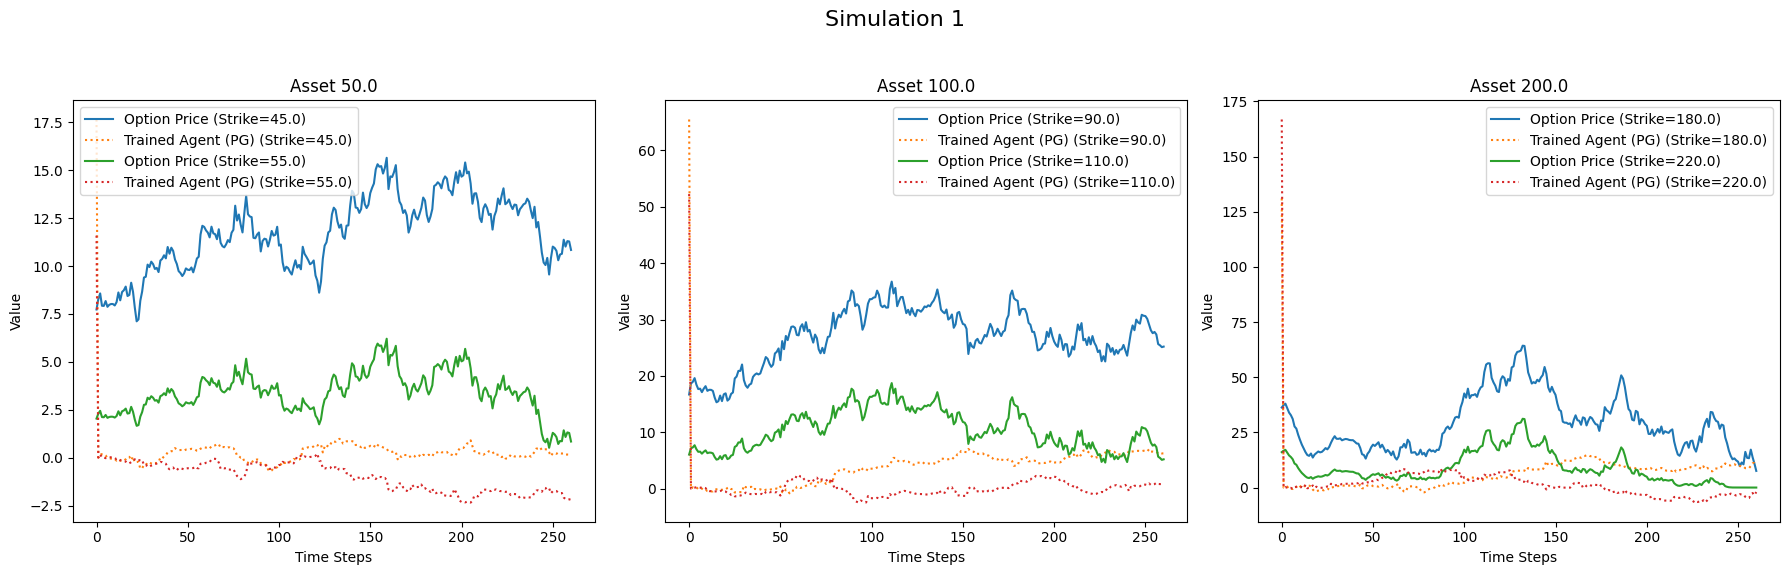

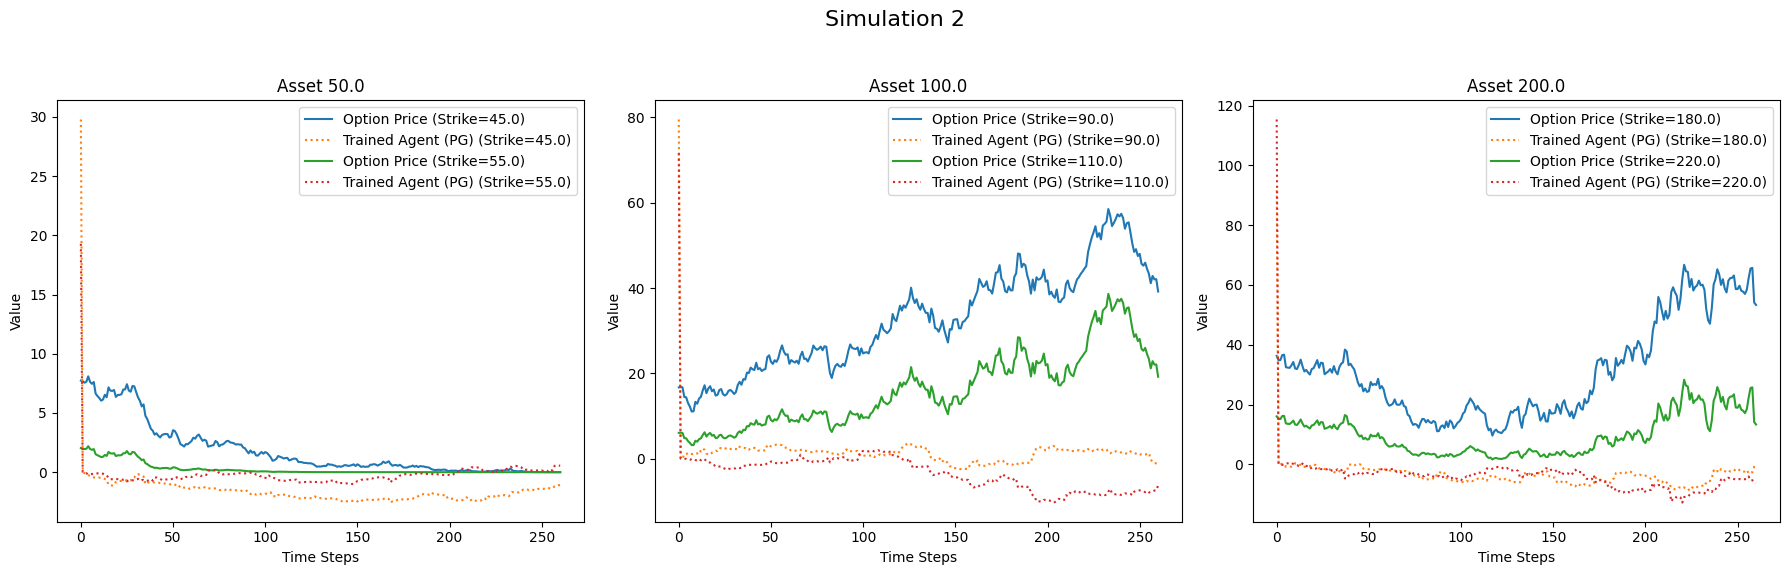

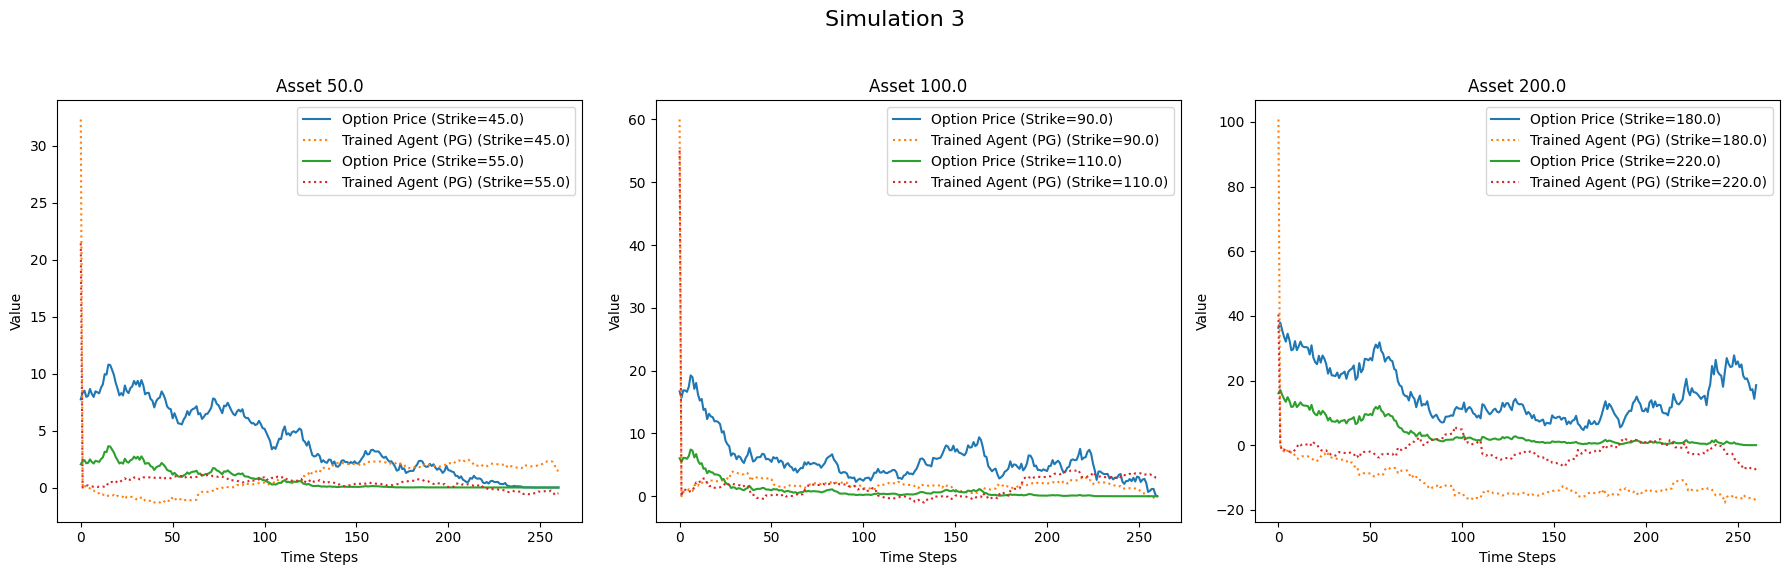

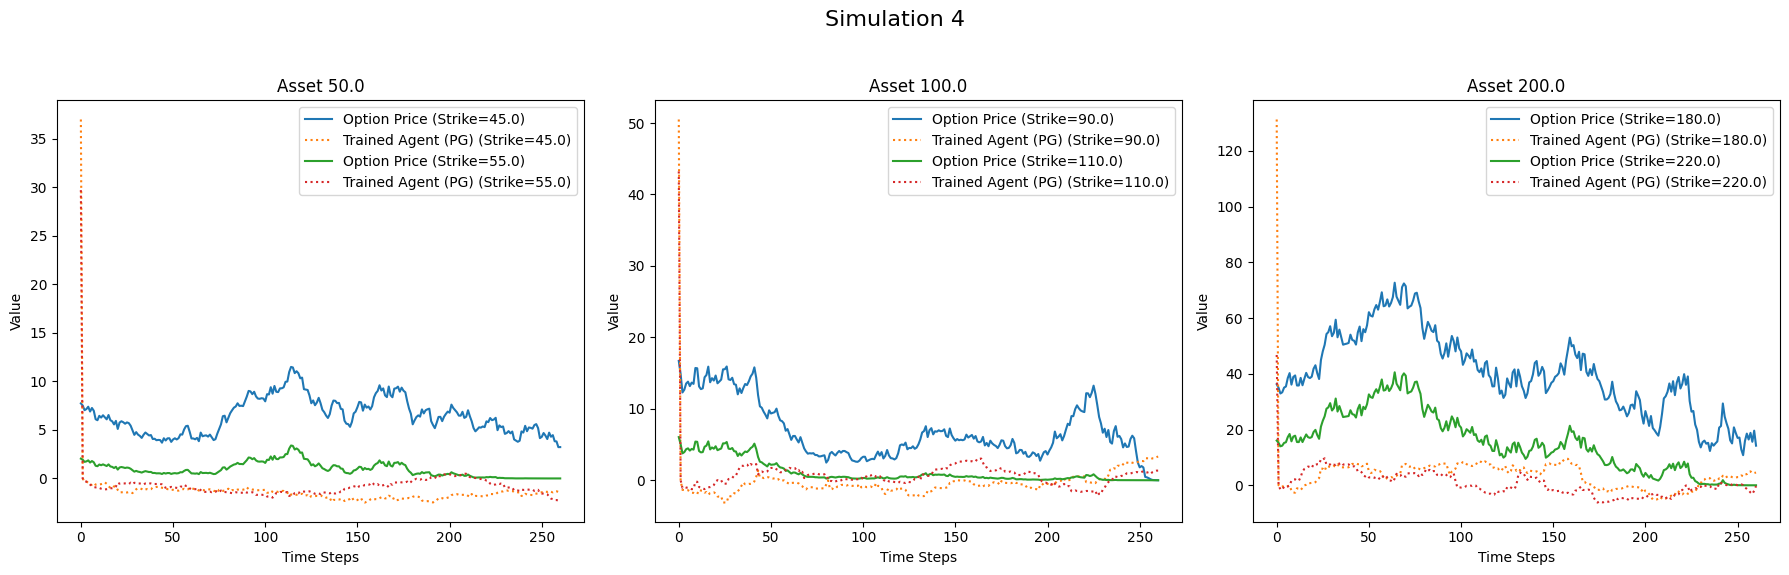

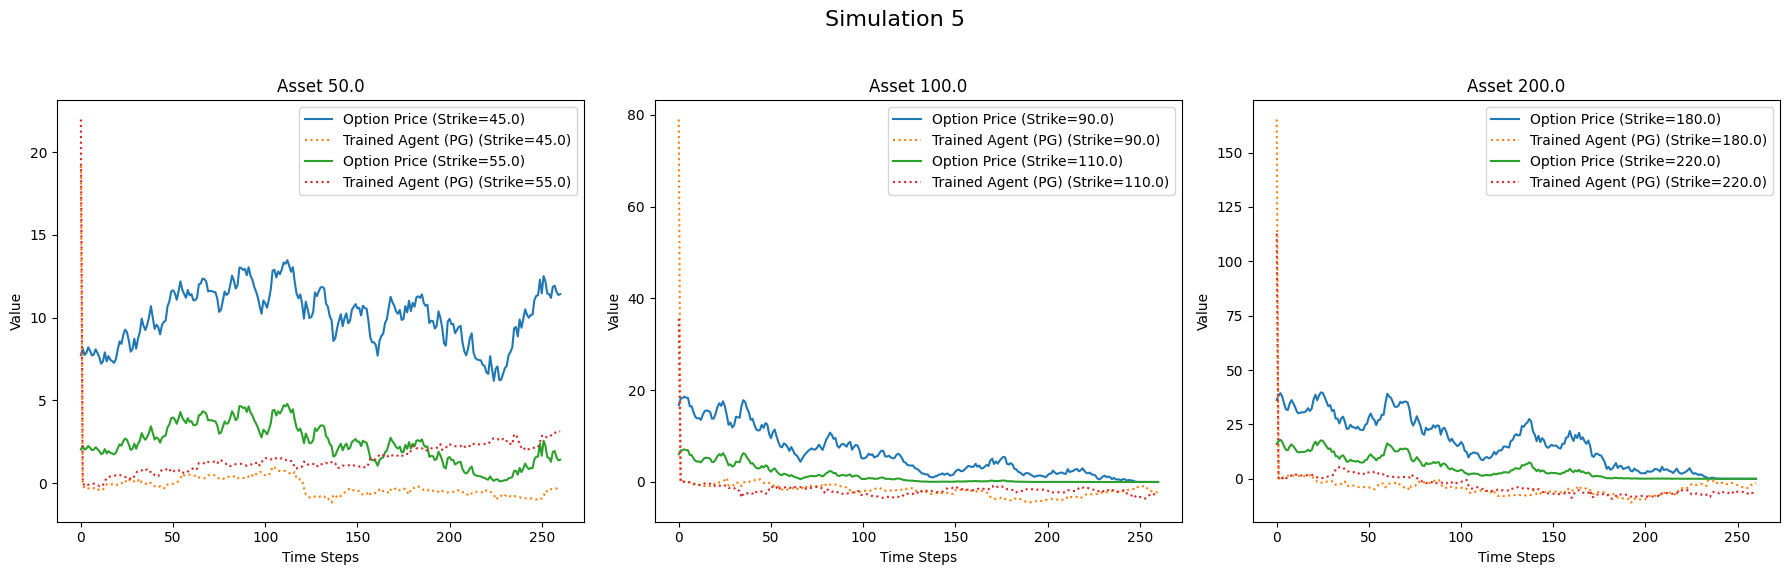

In [6]:
# --- Testing Parameters (same as before) ---
S0 = np.array([50.0, 100.0, 200.0])
K = np.array([[45.0, 55.0], [90.0, 110.0], [180.0, 220.0]])
sigma = np.array([0.15, 0.2, 0.25])
r = 0.05
num_simulation_test = 5 # Reduced simulations for plotting
num_step = 260
history_len = 10
input_dim = 6 # Feature dimension

num_asset = len(S0)
num_strike = K.shape[1]

# --- Initialize Test Environment and Policy Network ---
test_env = HedgingEnv(S0, K, sigma, r, num_simulation_test, num_step, seed=10) # Different seed for test
policy_net = trained_policy # Use the trained policy from the training phase
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net.to(device).eval() # Set policy network to evaluation mode

# --- Initialize Portfolio Value Arrays ---
option_prices_np = test_env.option_prices
portfolio_value_trained = np.zeros_like(option_prices_np)

# --- Trained Policy Agent Simulation ---
test_env.reset()
shares_held_trained = np.zeros((num_simulation_test, num_asset, num_strike))
state_history_test = []
state_test = test_env.reset() # Get initial state for test
state_test_torch = torch.tensor(state_test, dtype=torch.float32).to(device)

for step in range(num_step):
    # Prepare history features for LSTM input
    current_state_history_test = torch.stack(state_history_test[-history_len:] if len(state_history_test) > 0 else [torch.zeros_like(state_test_torch[0]) for _ in range(history_len)], dim=1) if len(state_history_test) > 0 else torch.zeros(num_simulation_test * num_asset * num_strike, history_len, state_test_torch.shape[-1]).to(device) # zero pad at beginning

    # Get features for current step
    current_state_history_test = torch.cat([current_state_history_test[:, 1:, :], state_test_torch.unsqueeze(1)], dim=1) if len(state_history_test) > 0 else torch.cat([torch.zeros(num_simulation_test * num_asset * num_strike, history_len-1, state_test_torch.shape[-1]).to(device), state_test_torch.unsqueeze(1)], dim=1)

    with torch.no_grad(): # Disable gradient calculation during testing
        mu_test, sigma_test = policy_net(current_state_history_test)
        action_shares_to_hold_test, _ = select_action(mu_test.view(-1), sigma_test.view(-1))

    # Convert action to numpy and reshape
    action_shares_to_hold_test_np = action_shares_to_hold_test.cpu().detach().numpy()
    action_shares_to_hold_test_reshaped = action_shares_to_hold_test_np.reshape(num_simulation_test, num_asset, num_strike)

    shares_to_trade_trained = action_shares_to_hold_test_reshaped - shares_held_trained
    next_state_test, reward_test, done_test, _ = test_env.step(shares_to_trade_trained.reshape(-1,))
    portfolio_value_trained[..., step+1] = test_env.cash_account[..., step+1] + test_env.shares_held[..., step+1] * test_env.stock_prices[:, :, None, step+1]
    shares_held_trained = action_shares_to_hold_test_reshaped

    state_history_test.append(state_test_torch)
    state_test = next_state_test
    state_test_torch = torch.tensor(state_test, dtype=torch.float32).to(device)


portfolio_value_trained[...,0] = test_env.cash_account[...,0] + shares_held_trained * test_env.stock_prices[...,0, None]


# --- Plotting (Reused and adapted from previous response) ---
for idx in range(num_simulation_test):
    fig, axes = plt.subplots(1, len(K), figsize=(18, 6))
    fig.suptitle(f'Simulation {idx+1}', fontsize=16)

    for i in range(num_asset):
        for j in range(num_strike):
            axes[i].plot(option_prices_np[idx, i, j, :], linestyle='-', label=f'Option Price (Strike={K[i,j]})')
            axes[i].plot(portfolio_value_trained[idx, i, j, :], linestyle=':', label=f'Trained Agent (PG) (Strike={K[i,j]})') # Added trained agent plot

        axes[i].set_title(f'Asset {S0[i]}')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel('Value')
        axes[i].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()